# $k$-Means Clustering for Device Port Data Traffic of STREAM on Ampere Altra

This is the script that generates Fig. 7 of the paper.

### 1. Read the output of Linux perf

In [11]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

file_path = '../data/perf.data.stream'
perf_data= pd.read_csv(file_path, sep=';', header=None, names=['count', 'event_name'], usecols=[0, 2])

perf_data

,count,event_name
0,11353848,"arm_cmn_0/mxp_p0_dat_txflit_valid,bynodeid=1,n..."
1,0,"arm_cmn_0/mxp_p1_dat_txflit_valid,bynodeid=1,n..."
2,8116559507,"arm_cmn_0/mxp_p0_dat_txflit_valid,bynodeid=1,n..."
3,5696111314,"arm_cmn_0/mxp_p1_dat_txflit_valid,bynodeid=1,n..."
4,8069236735,"arm_cmn_0/mxp_p0_dat_txflit_valid,bynodeid=1,n..."
...,...,...
91,5729517337,"arm_cmn_0/mxp_p1_dat_txflit_valid,bynodeid=1,n..."
92,8122807662,"arm_cmn_0/mxp_p0_dat_txflit_valid,bynodeid=1,n..."
93,5733759174,"arm_cmn_0/mxp_p1_dat_txflit_valid,bynodeid=1,n..."
94,0,"arm_cmn_0/mxp_p0_dat_txflit_valid,bynodeid=1,n..."


### 2. Clustering based on the event counts

In [12]:
event_counts = perf_data.iloc[:, 0].values.reshape(-1, 1)

kmeans = KMeans(n_clusters=4, random_state=0).fit(event_counts)
labels = kmeans.labels_
perf_data['label'] = labels

perf_data

,count,event_name,label
0,11353848,"arm_cmn_0/mxp_p0_dat_txflit_valid,bynodeid=1,n...",2
1,0,"arm_cmn_0/mxp_p1_dat_txflit_valid,bynodeid=1,n...",2
2,8116559507,"arm_cmn_0/mxp_p0_dat_txflit_valid,bynodeid=1,n...",3
3,5696111314,"arm_cmn_0/mxp_p1_dat_txflit_valid,bynodeid=1,n...",1
4,8069236735,"arm_cmn_0/mxp_p0_dat_txflit_valid,bynodeid=1,n...",3
...,...,...,...
91,5729517337,"arm_cmn_0/mxp_p1_dat_txflit_valid,bynodeid=1,n...",1
92,8122807662,"arm_cmn_0/mxp_p0_dat_txflit_valid,bynodeid=1,n...",3
93,5733759174,"arm_cmn_0/mxp_p1_dat_txflit_valid,bynodeid=1,n...",1
94,0,"arm_cmn_0/mxp_p0_dat_txflit_valid,bynodeid=1,n...",2


### 3. Visualize the clustering result

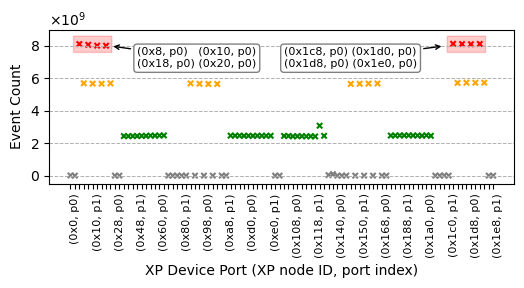

In [13]:
from matplotlib.colors import ListedColormap
from matplotlib.ticker import ScalarFormatter
import re

custom_cmap = ListedColormap(['green', 'orange', 'gray', 'red'])

plt.figure(figsize=(6, 2))

plt.scatter(range(len(event_counts)), event_counts, c=labels, cmap=custom_cmap, marker='x', s=15)
plt.xlabel('XP Device Port (XP node ID, port index)')
plt.ylabel('Event Count')

plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))    # y-axis: scientific notation
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

plt.gca().grid(axis='y', linestyle='--', linewidth=0.7)    # y-axis: horizontal dashed line

# Convert event names to (XP node IDs, ports)
device_ports = []
for index, row in perf_data.iterrows():
    event_name: str = row['event_name']
    port = event_name[14:16]    # port: p0 or p1
    node_id = re.search(r'nodeid=([^/]+)/', event_name).group(1)[9:]    # XP node ID: 0x..
    device_ports.append(f'({node_id}, {port})')

# Show a tick every 5 ticks
plt.gca().set_xticks(range(len(device_ports)))
plt.gca().set_xticklabels(
    [label if i % 5 == 0 else '' for i, label in enumerate(device_ports)],
    rotation=90, 
    ha='left'
)
plt.gca().tick_params(axis='x', labelsize=8)

plt.gca().set_ylim(-0.5e9, 9e9)

plt.annotate("(0x8, p0)   (0x10, p0)\n(0x18, p0) (0x20, p0)", 
             xy = (9, 8e9), xytext= (15, 6.7e9), 
             arrowprops = dict(arrowstyle="->"),
             bbox=dict(boxstyle="round", fc="white", ec="gray"), fontsize=8)
plt.annotate("(0x1c8, p0) (0x1d0, p0)\n(0x1d8, p0) (0x1e0, p0)", 
             xy = (84, 8e9), xytext= (48, 6.7e9), 
             arrowprops = dict(arrowstyle="->"),
             bbox=dict(boxstyle="round", fc="white", ec="gray"), fontsize=8)

rect = FancyBboxPatch(xy=(1, 7.6e9), width=8, height=1e9, boxstyle="round", color="red", alpha=0.2)
plt.gca().add_patch(rect)
rect = FancyBboxPatch(xy=(85, 7.6e9), width=8, height=1e9, boxstyle="round", color="red", alpha=0.2)
plt.gca().add_patch(rect)

# Save as a PDF
plt.savefig('clustering_data_traffic.pdf', format='pdf', bbox_inches='tight')

plt.show()

#### Observation

- **The red cluster**: with the highest data traffic, 8 in total. They are memory controllers (SN-Fs). The memory requests from RN-Fs are sent to memory controllers. 

- **The yellow cluster**: with the second highest data traffic, 16 in total. They are SLC slices (HN-Fs). The memory requests from RN-Fs are always sent to the SLC before memory controllers.

- **The green cluster**: with the second lowest value, 40 in total. They correspond to the DSUs composed of two CPU cores (RN-Fs), and the data traffic to the memory controller is generated from them. 

- **The grey cluster**: with the lowest value (close to 0). They correspond to other irrelevant nodes. 

### 4. Filter and output the physical location of the memory controllers

Find the smallest cluster (or the cluster with the highest average data traffic).

In [14]:
label_counts = perf_data['label'].value_counts()
least_common_label = label_counts.idxmin()

selected_perf_data = perf_data[perf_data['label'] == least_common_label]
selected_perf_data

,count,event_name,label
2,8116559507,"arm_cmn_0/mxp_p0_dat_txflit_valid,bynodeid=1,n...",3
4,8069236735,"arm_cmn_0/mxp_p0_dat_txflit_valid,bynodeid=1,n...",3
6,8019030850,"arm_cmn_0/mxp_p0_dat_txflit_valid,bynodeid=1,n...",3
8,8015415466,"arm_cmn_0/mxp_p0_dat_txflit_valid,bynodeid=1,n...",3
86,8132728568,"arm_cmn_0/mxp_p0_dat_txflit_valid,bynodeid=1,n...",3
88,8116390866,"arm_cmn_0/mxp_p0_dat_txflit_valid,bynodeid=1,n...",3
90,8104694276,"arm_cmn_0/mxp_p0_dat_txflit_valid,bynodeid=1,n...",3
92,8122807662,"arm_cmn_0/mxp_p0_dat_txflit_valid,bynodeid=1,n...",3


In [15]:
for index, row in selected_perf_data.iterrows():
    event_name: str = row['event_name']
    port = int(event_name[15])
    nodeid = event_name.split('/')[1].split(',')[2][7:]
    print(f'port: {port}, nodeid: {nodeid}')

port: 0, nodeid: 0x8
port: 0, nodeid: 0x10
port: 0, nodeid: 0x18
port: 0, nodeid: 0x20
port: 0, nodeid: 0x1c8
port: 0, nodeid: 0x1d0
port: 0, nodeid: 0x1d8
port: 0, nodeid: 0x1e0
